# Music Authorship

* Find this notebook at `EpyNN/nnlive/author_music/prepare_dataset.ipynb`. 
* Regular python code at `EpyNN/nnlive/author_music/prepare_dataset.py`.

This notebook is part of the series on preparing data for Neural Network regression with EpyNN. 

It deals with a real world problem and therefore will focus on the problem itself, rather than basics that were reviewed along with the preparation of the following dummy dataset: 

* [Boolean dataset](../dummy_boolean/prepare_dataset.ipynb)
* [String dataset](../dummy_string/prepare_dataset.ipynb)
* [Time-series (numerical)](../dummy_time/prepare_dataset.ipynb)
* [Image (numerical)](../dummy_image/prepare_dataset.ipynb)

## Authorship prediction of artistic content

Detection of fake art is a challenge for a market reprotedly weighting more than 60 billions USD per year. Indeed, the price of an art piece is directly linked to its author and the more famous one author is, the more falsficiations are to be expected. You may like to visit [Deep learning approaches to pattern extraction and recognition in paintings and drawings](https://link.springer.com/article/10.1007/s00521-021-05893-z) for an overview of deep learning methods used to assign one painting to the corresponding author.

Herein, we are going to work with audio art or music. More specifically, we will prepare one *True* and *False* dataset from audio `.wav` files that may have been played by one author or another.

## Prepare music clips from .wav files

Audio files can contain music of any duration. Moreover, we may just have a single audio file for each of the *True* and *False* authors. Therefore, we need to make clips to have more than one training exemple per author, among other reasons.

### Imports

In [1]:
# EpyNN/nnlive/author_music/prepare_dataset.ipynb
# Standard library imports
import tarfile
import random
import glob
import os

# Related third party imports
import wget
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Local application/library specific imports
from nnlibs.commons.logs import process_logs

Note the `tarfile` which is a Python built-in *standard* library and the first choice to deal with `.tar` archives and related.

Note the import of `wavfile` from `scipy.io`. Scipy is a [*"Python-based ecosystem of open-source software for mathematics, science, and engineering"*](https://www.scipy.org/) while the [wavfile](https://docs.scipy.org/doc/scipy/reference/io.html?highlight=wavfile#module-scipy.io.wavfile) module provides easy-to-use read/write functions for audio `.wav` files.

In [2]:
### Seeding

In [3]:
random.seed(1)

For reproducibility.

### Download music from author A and B

Simple function to download data from the cloud as `.tar` archive. Once uncompressed, it yields a `data/` directory containing subdirectories `data/true` and `data/false` themselves containing audio `.wav` files.

In [4]:
def download_music():
    """Download some guitar music.
    """
    data_path = os.path.join('.', 'data')

    if not os.path.exists(data_path):

        # Download @url with wget
        url = 'https://synthase.s3.us-west-2.amazonaws.com/author_music.tar'
        fname = wget.download(url)

        # Extract archive
        tar = tarfile.open(fname).extractall('.')
        process_logs('Make: '+fname, level=1)

        # Clean-up
        os.remove(fname)

    return None

Retrieve the data as follows.

In [5]:
download_music()

Walk through the uncompressed archive directory to see what it actually contains.

In [6]:
for path in os.walk('data'):
    print(path)
    
wav_test = os.path.join('data', 'true', 'STE-001.wav')
print(wav_test)

('data', ['true', 'false'], [])
('data/true', [], ['STE-001.wav', 'STE-012.wav', 'STE-010.wav', 'STE-004.wav', 'STE-002.wav', 'STE-007.wav', 'STE-011.wav', 'STE-017.wav', 'STE-006.wav', 'STE-020.wav', 'STE-019.wav', 'STE-005.wav', 'STE-018.wav', 'STE-008.wav'])
('data/false', [], ['top_30_songs_acoustic_guitar.wav'])
data/true/STE-001.wav


These audio `.wav` files are acoustic guitare music. Credits to:

* *True* author: Ewen Lescop (ewen.lescop@cnrs.fr) who was my beloved PhD supervisor (first) in addition to be a great NMR scientist and guitare player (both second ex-aequo).
* *False* author: Paul Davids from Youtube, see [TOP 30 songs for ACOUSTIC guitar!](https://www.youtube.com/watch?v=T-U3c1nU3eM) for the original content.

### Clip music

By clipping music we mean make chunks of it. We need a ``TIME`` for one clip, which defaults to ``1`` second. 

Also, we will apply some resampling, because the ``.wav`` file has sampling rate of 44100 Hz which means 44100 data point per second. This is a lot when considering that we will later retrieve many clips of one second. Indeed, while one ``.wav`` file weights only a few MB, it weights much more when embedded into NumPy arrays. To prevent from overloading the RAM, we then need to reduce the number of data points per clips. This ``SAMPLING_RATE`` defaults to 10000 Hz and as a consequence we will loose most of the patterns whose frequency is higher than 5000 Hz (See [Nyquist rate](https://en.wikipedia.org/wiki/Nyquist_rate) for more).

Fortunately, the highest pitch guitare can play is lower than 5000 Hz (See [Range (music)](https://en.wikipedia.org/wiki/Range_(music)) for more). Although harmonics can go beyond this limit, we may expect to not loose the patterns or signatures for each of the *True* and *False* authors. 

In [7]:
def clips_music(wav_file, TIME=1, SAMPLING_RATE=10000):
    """Clip music and proceed with resampling.

    :param wav_file: The filename of .wav file which contains the music.
    :type wav_file: str

    :param SAMPLING_RATE: Sampling rate (Hz), default to 10000.
    :type SAMPLING_RATE: int

    :param TIME: Sampling time (s), defaults to 1.
    :type TIME: int

    :return: Clipped and re-sampled music.
    :rtype: list[:class:`numpy.ndarray`]
    """
    # Number of features describing a sample
    N_FEATURES = int(SAMPLING_RATE * TIME)

    # Retrieve original sampling rate (Hz) and data
    wav_sampling_rate, wav_data = wavfile.read(wav_file)

    # 16-bits wav files - Pass all positive and norm. [0, 1]
    wav_data = (wav_data + np.abs(np.min(wav_data)))
    wav_data = wav_data / np.max(wav_data)

    # Digitize in 4-bits signal
    n_bins = 16
    bins = [i / (n_bins - 1) for i in range(n_bins)]
    wav_data = np.digitize(wav_data, bins, right=True)

    # Compute step for re-sampling
    sampling_step = int(wav_sampling_rate / SAMPLING_RATE)

    # Re-sampling to avoid memory allocation errors
    wav_resampled = wav_data[::sampling_step]

    # Total duration (s) of original data
    wav_time = wav_data.shape[0] / wav_sampling_rate

    # Number of clips to slice from original data
    N_CLIPS = int(wav_time / TIME)

    # Make clips from data
    clips = [wav_resampled[i * N_FEATURES:(i+1) * N_FEATURES] for i in range(N_CLIPS)]

    return clips

In addition to clipping and resampling, we have done the following signal normalization within \[0, 1\]: Audio files 16-bits encoded are lists of integers ranging from -32768 , +32767 for a total of 2^16 bins. We need to normalize within \[0, 1\] for one technical reason: such high values are likely to generate floatting point errors when passed through exponential functions, among others. 

In [8]:
print(np.exp(32767))

inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


Normalization was achieved on a per-file basis, because we assume that global sound level may be different from one recording to the other or from one author to the other. Therefore, the minimum and maximum sound level in one file will be equal to zero and one, respectively, after normalization. In addition to prevent from floatting point errors, this helps to make further network training faster because the network does not need to perform such normalization by itself.

The last thing we have done is signal re-digitalization using a 4-bits encoder over 16 bins. This because we make the choice to later one-hot encode these data. When doing the latter, we loose information over signal amplitude and we focus on patterns in signal.

We can now see how it looks like with different settings for the same clip length:

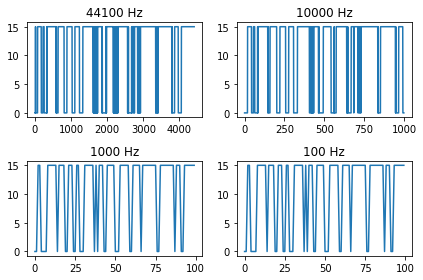

In [9]:
fig, ax = plt.subplots(2, 2)

clips = clips_music(wav_test, TIME=0.1, SAMPLING_RATE=44100)
ax[0, 0].plot(clips[0])
ax[0, 0].set_title('44100 Hz')

clips = clips_music(wav_test, TIME=0.1, SAMPLING_RATE=10000)
ax[0, 1].plot(clips[0])
ax[0, 1].set_title('10000 Hz')

clips = clips_music(wav_test, TIME=0.1, SAMPLING_RATE=1000)
ax[1, 0].plot(clips[0])
ax[1, 0].set_title('1000 Hz')

clips = clips_music(wav_test, TIME=0.1, SAMPLING_RATE=1000)
ax[1, 1].plot(clips[0])
ax[1, 1].set_title('100 Hz')

plt.tight_layout()
plt.show()

Along with the decreasing sampling rate, we observe that patterns corresponding with higher frequencies are eliminated. You may have observed that the 4-bits encoding is responsible for signal truncation at the upper and lower bounds, or signal overflow, but this will not be a problem we consider here.

### Prepare dataset

Below is a function we use to prepare the labeled dataset.

In [10]:
def prepare_dataset(N_SAMPLES=100):
    """Prepare a dataset of clipped music as NumPy arrays.

    :param N_SAMPLES: Number of clip samples to retrieve, defaults to 100.
    :type N_SAMPLES: int

    :return: Set of sample features.
    :rtype: tuple[:class:`numpy.ndarray`]

    :return: Set of single-digit sample label.
    :rtype: tuple[:class:`numpy.ndarray`]
    """
    # Initialize X and Y datasets
    X_features = []
    Y_label = []

    wav_paths = os.path.join('data', '*', '*wav')

    wav_files = glob.glob(wav_paths)

    # Iterate over WAV_FILES
    for wav_file in wav_files:

        # Retrieve clips
        clips = clips_music(wav_file)

        # Iterate over clips
        for features in clips:

            # Clip is positive if played by true author (+) else negative (-)
            label = 1 if 'true' in wav_file else 0

            # Append sample features to X_features
            X_features.append(features)

            # Append sample label to Y_label
            Y_label.append(label)

    # Prepare X-Y pairwise dataset
    dataset = list(zip(X_features, Y_label))

    # Shuffle dataset
    random.shuffle(dataset)

    # Truncate dataset to N_SAMPLES
    dataset = dataset[:N_SAMPLES]

    # Separate X-Y pairs
    X_features, Y_label = zip(*dataset)

    return X_features, Y_label

Let's check the function.

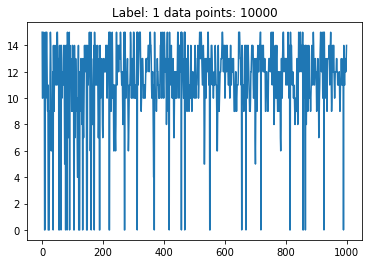

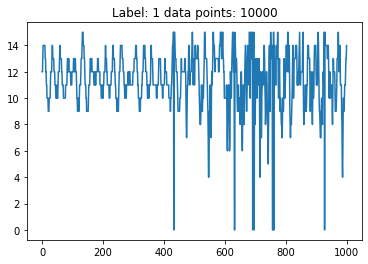

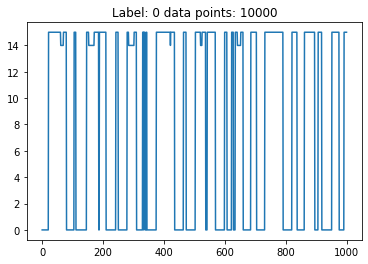

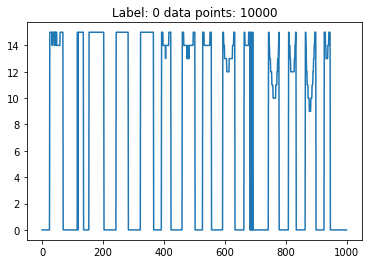

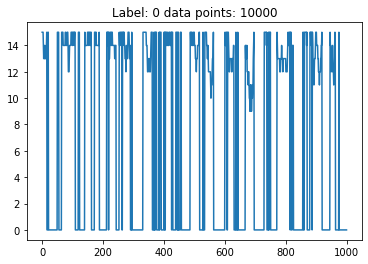

In [11]:
X_features, Y_label = prepare_dataset(N_SAMPLES=5)

for features, label in zip(X_features, Y_label):
    plt.plot(features[:features.shape[0] // 10])
    plt.title('Label: %s data points: %s' % (label, features.shape[0]))
    plt.show()

We are ready to proceed with the training of a network based on those data.

## Live examples

The function ``prepare_dataset()`` presented herein is used in the following live examples:

* Notebook at`EpyNN/nnlive/author_music/train.ipynb` or following [this link](train.ypinb). 
* Regular python code at `EpyNN/nnlive/author_music/train.py`.